In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
from datetime import datetime
import time 
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
import scipy.stats
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from sklearn.linear_model import BayesianRidge, HuberRegressor, Ridge, OrthogonalMatchingPursuit
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import optuna
#from xgboost import XGBRegressor
#from pycaret.regression import setup, compare_models, models
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p
from sklearn import linear_model
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

## Load the data

In [2]:
df_train = pd.read_csv('Ames_Housing_Price_Data.csv',index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'Ames_Housing_Price_Data.csv'

In [ ]:
df_raw=df_train.copy()

## Examine the data

In [ ]:
df_train.shape

In [ ]:
df_train.head(10)

In [ ]:
#Check the number of NAs in each column
df_train.isna().sum()

# Data Cleaning/Preprocessing

In [ ]:
target=df_train.SalePrice

In [ ]:
test_ids=df_train.PID

In [ ]:
df_train=df_train.drop(columns=['PID', 'SalePrice'])

In [ ]:
df_train_copy=df_train.copy()

### Use .info() to see length and dtypes

In [ ]:
df_train.info()

## Identify numerical and categorical variables

In [ ]:
cols_list=list(df_train.columns)
cols_list

In [ ]:
#MSSUBClass is actually a categoical data coluumn per the data descrpition text file
df_train.MSSubClass=df_train.MSSubClass.astype(str)

In [ ]:
#looking at columns that consist of numberic values only
df_train.select_dtypes("number")
#df_train._get_numeric_data()

# (Moved to later) Remove features based on correlation to avoid multicollinearity 

In [ ]:
#corr=df_train.corr()
#plt.figure(figsize = (16, 16))
#sns.heatmap(corr,
#           xticklabels=corr.columns.values,
#           yticklabels=corr.columns.values, cmap="Blues")

#plt.title('Heatmap of Correlation Matrix')
#corr

In [ ]:
#high_corr_pairs = np.where(abs(corr) > 0.7)
#high_corr_pairs = [(corr.index[x], corr.columns[y]) for x, y in zip(*high_corr_pairs)
                                        #if x != y and x < y]
#high_corr_pairs

### Per the data description, 
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

TotalBsmtSF=BsmtFinSF1+BsmtFinSF2+BsmtUnfSF

GrLivArea=1stFlrSF+2ndFlrSF+LowQualFinSF

In [ ]:
#Dropping numerical columns of which have high correaltion with one another
#df_train=df_train.drop(["TotRmsAbvGrd","GarageYrBlt","GarageArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","1stFlrSF","2ndFlrSF","LowQualFinSF"],axis=1)

## Data Inputation

### Categorical

In [ ]:
#Show all column names with missing values
df_train.columns[df_train.isnull().any()]

In [ ]:
#Show all categorical/object columns with missing values
df_train.select_dtypes("object").isna().sum()!=0

In [ ]:
#Fill NAs in these columns with None when a missing value means something
#e.g. NA basement means no basement

for column in ["Alley",
               "MasVnrType",
               "BsmtQual",
               "BsmtCond",
               "BsmtExposure",
               "BsmtFinType1",
               "BsmtFinType2",
               "FireplaceQu",
               "GarageType",
               "GarageFinish",
               "GarageQual",
               "GarageCond",
               "PoolQC",
               "Fence",
               "MiscFeature"]:
    df_train[column]=df_train[column].fillna("None")

In [ ]:
#Fill NAs in these columns with mode
for column in ["MasVnrType","Electrical"]:
    df_train[column]=df_train[column].fillna(df_train[column].mode()[0])

In [ ]:
df_train.select_dtypes("object").isna().sum()

## Numerical

In [ ]:
df_train.select_dtypes("number").isna().sum()

In [ ]:
#Show all numeric columns with missing values
df_train.select_dtypes("number").isna().sum()!=0

In [ ]:
for column in ["MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","BsmtFullBath","BsmtHalfBath","GarageCars","GarageArea"]:
    df_train[column]=df_train[column].fillna(df_train[column].median())

In [ ]:
for column in ["GarageYrBlt"]:
    df_train[column]=df_train[column].fillna(df_train[column].mode()[0])

In [ ]:
df_train.groupby("Neighborhood").LotFrontage.median()

In [ ]:
df_train.loc[df_train["Neighborhood"].isin(['Landmrk','GrnHill'])]

In [ ]:
#Impute missing values in LotFrontage with the median by Neighborhood 
df_train["LotFrontage"] = df_train["LotFrontage"].fillna(df_train.groupby("Neighborhood")['LotFrontage'].transform('median'))

In [ ]:
#Fill the remaining 3NAs of LotFrontage with the Median of all LotFrontage
df_train["LotFrontage"]=df_train["LotFrontage"].fillna(df_train["LotFrontage"].median())

In [ ]:
df_train.select_dtypes("number").isna().sum()

In [ ]:
df_train.isna().sum()
#Check if there're still any missing values

## Summarize numberical and categorical variables separately

In [ ]:
df_train.describe(include=[np.number])

In [ ]:
df_train.describe(include=['O']) #The 'O' stands for objects

# Feature Transformations

In [ ]:
df_train.select_dtypes("number")

In [ ]:
numeric_cols=df_train.select_dtypes("number").columns

In [ ]:
numeric_cols=pd.DataFrame(numeric_cols,columns=["Features"])

In [ ]:
numeric_cols

In [ ]:
scipy.stats.skew(df_train.select_dtypes("number"))

In [ ]:
numeric_cols["Skewness"]=scipy.stats.skew(df_train.select_dtypes("number"))
df_skew=numeric_cols.copy()
df_skew
#0 means no skew and normally distributed
#+ve number means right skew
#-ve number means left skew

In [ ]:
df_skew["Absolute_Skew"]=np.abs(df_skew["Skewness"])

In [ ]:
df_skew

In [ ]:
df_skew["Skewed"]=np.where(df_skew['Absolute_Skew'] > 0.75, True, False)

In [ ]:
#Looks like half of the features are skewed.... (Absolute Skew>0.75)
df_skew.sort_values("Absolute_Skew")

In [ ]:
df_skew[df_skew.Skewed==True].Features.values
#get all the features which are skewed

In [ ]:
df_skew[df_skew.Skewed==True].Features

In [ ]:
#Check to see how those skewed columns are distributed
df_train[df_skew[df_skew.Skewed==True].Features.values].describe()

In [ ]:
df_before_feature_transformed=df_train.copy()

In [ ]:
df_skewed_features=df_train[df_skew[df_skew.Skewed==True].Features.values]
df_skewed_features

In [ ]:
lam = 0.15
for col in df_skewed_features.columns:
    df_train[col]=boxcox1p(df_train[col], lam)

In [ ]:
numeric_cols["Skewness"]=scipy.stats.skew(df_train.select_dtypes("number"))
df_skew=numeric_cols.copy()
df_skew["Absolute_Skew"]=np.abs(df_skew["Skewness"])
df_skew["Skewed"]=np.where(df_skew['Absolute_Skew'] > 0.75, True, False)
df_skew.sort_values("Absolute_Skew",ascending=False)
#The number of skewed feaetures has gone down from 16 to 11
#after the BoxCox1p transformation

## Transform Months/Cyclincal Features With Cosine Wave 

In [ ]:
df_train.MoSold.value_counts().index.sort_values() #Month Sold
#It's cyclical. However, models may not be able to tell 

In [ ]:
#A negative cosine wave (y=-cos(x)) can represent this pattern, 
#where month 1 and month 12 are similar and start from the same point
#high values mean hot and low values mean cold
#-cos(0.5x)

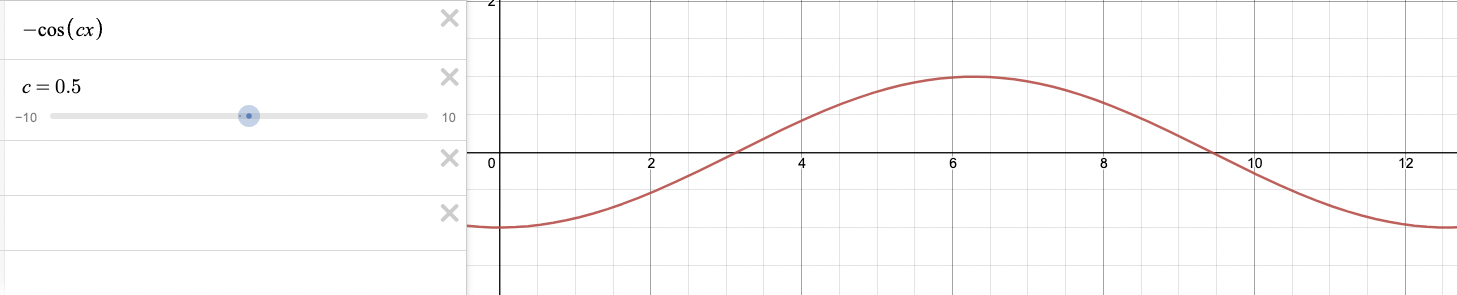

In [ ]:
-np.cos(0.5*df_train.MoSold)

In [ ]:
(-np.cos(0.5*df_train.MoSold)).describe()
#after the transformation, the min is closed to -1 and the max is closed to 1

In [ ]:
df_train.MoSold=-np.cos(0.5*df_train.MoSold)

# Encode Categoical Columns (after ensuring the dtype of those columns is string)

In [ ]:
df_train=pd.get_dummies(df_train, drop_first=True)

In [ ]:
df_train.head()

# Standardization/Standard Scaling

In [ ]:
standard=StandardScaler() #give each column the same range of values and centered around 0
standard.fit(df_train)
df_train=pd.DataFrame(standard.transform(df_train), index=df_train.index, columns=df_train.columns)

In [ ]:
df_train

In [ ]:
#In production, use pipeline to encode and standard scale
#pd.get_dummies(df_test)
#
#df_dummmied=pd.get_dummies()
#pipe = Pipeline(
#    [("standardize", StandardScaler()), ("df_dummmied", df_dummmied)])

# Target Transformation

In [ ]:
target.hist()
#the target Sale Price is right skewed

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title("Sale Price Before Log Transform")
sns.distplot(target,fit=scipy.stats.norm)
#the data's density plot does not lie up with a normal distrubtion very well

plt.subplot(1, 2, 2)
plt.title("Sale Price After Log Transform")
sns.distplot(np.log(target),fit=scipy.stats.norm)
plt.xlabel("Sale Price (Log Scale)")
#the data's density plot fits much better with a normal distrubtion after the log transmation
plt.show()

In [ ]:
log_target=np.log(target)
#We're going to predict on the log Sale Price

In [ ]:
#After making prediction with our modeals, 
#we need get back to the original Sale Price by exponentiating
np.exp(log_target)

# Feature Selection (Forward Stepwise)

In [ ]:
#write a for loop for feature selectiopn 
#or use lasso to select the features 

In [ ]:
def forward_selection(data, target, significance_level=0.05):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
    return best_features
#from here 
#https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/

In [ ]:
forward_selected_features=forward_selection(df_train, log_target, significance_level=0.001)

In [ ]:
forward_selected_features

In [ ]:
len(forward_selected_features)

In [360]:
df_train_final=pd.DataFrame()

In [361]:
for feature in forward_selected_features:
    df_train_final[feature]=df_train[feature]
df_train_final.shape

(2580, 43)

# Modeling